In [25]:
import os
import sys
MODULE_FULL_PATH = '/home/spopov/focus/pfe'
sys.path.insert(1, MODULE_FULL_PATH)
sys.path.append('.')

import os
import sys
import time
import math
import argparse
import numpy as np

from network import Network
from utils import utils
from utils.dataset import Dataset
from utils.imageprocessing import preprocess

from retinaface import RetinaFace

from sklearn.cluster import DBSCAN

import align.crop_ijba as crop
import align.align_dataset as align



In [26]:
%matplotlib inline

from matplotlib import pyplot as plt

PFE_PATH='/home/spopov/focus/pfe'
DATASET_PATH = os.path.join(PFE_PATH, '/home/spopov/datadrive/IJB/IJB-B/')
HINTS_FILEPATH = os.path.join(DATASET_PATH, 'protocol/cluster/test8/ijbb_detection_clustering_hint_100000.csv')
IMAGES_PATH = os.path.join(DATASET_PATH, 'images/')
FACES_PATH = os.path.join(PFE_PATH, 'data/cluster/')

EVAL_SCRIPT_PATH = os.path.join(DATASET_PATH, 'cluster_eval/association_modified_bcubed.py')
GROUND_TRUTH_FILEPATH = os.path.join(DATASET_PATH, 'protocol/cluster/test8/ijbb_detection_clustering_ground_truth.csv')

TEMPLATES_FILEPATH = os.path.join(PFE_PATH, 'templates.csv')
CLUSTERS_FILEPATH = os.path.join(PFE_PATH, 'clusters.csv')

IMAGE_SIZE = [96, 112]

class Template:
    def __init__(self, template_id, filename, img, box, landmarks):
        self.template_id = template_id
        self.filename = filename
        self.img = img
        self.box = box
        self.landmarks = landmarks
        
        self.cluster_index = None
        self.confidence = None
        self.features = None
        
    def draw(self):
        if self.img is None:
            return
        
        imgg = self.img / np.max(self.img) # normalize the data to 0 - 1
        imgg = 255 * imgg # Now scale by 255
        imgg = imgg.astype(np.uint8)
        align_rgb = cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB)
        
        plt.figure()
        plt.imshow(align_rgb)
        plt.show()
    
    def __str__(self):
        return 'template_id: {}, filename: {},\nimg: {},\nbox: {},\nlandmarks: {}'.format(\
            self.template_id, self.filename, self.img, self.box, self.landmarks)

In [27]:
import pandas as pd

hints_filenames = pd.read_csv(HINTS_FILEPATH)
print(hints_filenames.shape)
print(hints_filenames.iloc[1][0])

(66779, 1)
frames/10003.png


In [28]:
gpuid = 0
detector = RetinaFace(os.path.join(PFE_PATH, 'model/R50'), 0, gpuid, 'net3')

network = Network()
network.load_model('/home/spopov/focus/pfe/log/sphere64_casia_am_PFE/20200515-123838')

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
means [0. 0. 0.]
use_landmarks True
cascade 0
sym size: 9
Metagraph file: /home/spopov/focus/pfe/log/sphere64_casia_am_PFE/20200515-123838/graph.meta
Checkpoint file: /home/spopov/focus/pfe/log/sphere64_casia_am_PFE/20200515-123838/ckpt-3000
INFO:tensorflow:Restoring parameters from /home/spopov/focus/pfe/log/sphere64_casia_am_PFE/20200515-123838/ckpt-3000


INFO:tensorflow:Restoring parameters from /home/spopov/focus/pfe/log/sphere64_casia_am_PFE/20200515-123838/ckpt-3000


In [29]:
import os
import glob
import cv2
from matplotlib import pyplot as plt
from ast import literal_eval

#         self.template_id = template_id
#         self.filename = filename
#         self.img = img
#         self.box = box
        
#         self.cluster_index = None
#         self.confidence = None
#         self.features = None
#         self.template_id = template_id
#         self.filename = filename
#         self.img = img
#         self.box = box
        
#         self.cluster_index = None
#         self.confidence = None
#         self.features = None


# templates_dict = {}
# for template in templates:

        
        
def template_dict(template):
    d = {'template_id': template.template_id,
        'filename': template.filename,
        'img': template.img,
        'box_x': template.box[0],
        'box_y': template.box[1],
        'box_w': template.box[2],
        'box_h': template.box[3],
#         'box': [template.box],
        'landmark': [template.landmarks],
#         'landmark_1': [template.landmarks[1]],
#         'landmark_2': [template.landmarks[2],
#         'landmark_3': template.landmarks[3],
#         'landmark_4': template.landmarks[4],
        }
    return d
    
def template_load(d):
#     template = Template(template_id, filename, impath_new, bbox, face_landmarks)
#     print('template_load: {}'.format(d))
    t = Template(d['template_id'], d['filename'], d['img'],
                np.array([ d['box_x'], d['box_y'], d['box_w'], d['box_h'] ]), None)
#                 np.array(literal_eval(d['box'])),
#                 np.array([ d['landmark_0'], d['landmark_1'], d['landmark_2'], d['landmark_3'], d['landmark_4'] ]))
#                 np.array(literal_eval(d['landmark'])))
    return t
    
def templates_load(df):
    templates = [template_load(row) for index, row in df.iterrows()]
    return templates

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

MAX_HEIGHT=2500
MAX_WIDTH=2500

def build_templates(num=None, start_idx=0, start_template_id=0, init=False):
    
    if num is None:
        num = hints_filenames.shape[0]
        
    COLUMN_NAMES=['template_id', 'filename', 'img', 'box_x', 'box_y', 'box_w', 'box_h', 'landmark']
#'landmark_0', 'landmark_1', 'landmark_2', 'landmark_3', 'landmark_4']
#     COLUMN_NAMES=['template_id', 'filename', 'img', 'box', 'landmark']
    if init:
        templates_df = pd.DataFrame(columns=COLUMN_NAMES)
        templates_df.to_csv(TEMPLATES_FILEPATH, index=False)
    
    template_id = start_template_id
    for filename_i, filename in enumerate(hints_filenames['FILENAME'][start_idx:num], start_idx):
        image_path = os.path.join(IMAGES_PATH, filename)
        img = cv2.imread(image_path, flags=1)
        height, width = img.shape[:2]
        
        if height > MAX_HEIGHT:
            img = image_resize(img, height=MAX_HEIGHT)
        height, width = img.shape[:2]
        if width > MAX_WIDTH:
            img = image_resize(img, width=MAX_WIDTH)
            
        height, width = img.shape[:2]
        print('image size: {}x{}'.format(width, height))
        
        if filename_i % 200 == 0:
            print('\r{} of {} images scanned for faces'.format(filename_i, num))
        if img is None or img.ndim == 0:
            print('Invalid image: %s' % impath)
            count_fail += 1
            continue

        faces, landmarks = detector.detect(img)

        if faces is None:
            continue

        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for face_i in range(faces.shape[0]):
            box = faces[face_i].astype(np.int)

            bbox = np.array([box[0], box[1], box[2] - box[0], box[3] - box[1]])

            face_landmarks = landmarks[face_i]
            src_pts = [[face_landmarks[j][0], face_landmarks[j][1]] for j in range(5)]
            align_img, _, _ = align.align(img, src_pts, align.ref_pts, IMAGE_SIZE)
        
            impath_new = os.path.join(FACES_PATH, '{}_{}.jpg'.format(filename_i, face_i))
            cv2.imwrite(impath_new, align_img)

            template = Template(template_id, filename, impath_new, bbox, face_landmarks)
            template_id += 1
            
            template = template_dict(template)
#             print(template)
            templates_df = pd.DataFrame(template)
            templates_df.to_csv(TEMPLATES_FILEPATH, mode='a', header=False, index=False)


In [30]:
import random

def force_compare(compare_func, verbose=False):
    def compare(t1, t2):
        score_vec = np.zeros(len(t1))
        for i in range(len(t1)):
            if t1[i] is None or t2[i] is None:
                score_vec[i] = 0
            else:
                score_vec[i] = compare_func(t1[i][None], t2[i][None])
            if verbose and i % 1000 == 0:
                sys.stdout.write('Matching pair {}/{}...\t\r'.format(i, len(t1)))
        if verbose:
            print('')
        return score_vec
    return compare

def pair_MLS_score(x1, x2, sigma_sq1=None, sigma_sq2=None):
    if sigma_sq1 is None:
        x1, x2 = np.array(x1), np.array(x2)
        assert sigma_sq2 is None, 'either pass in concated features, or mu, sigma_sq for both!'
        D = int(x1.shape[1] / 2)
        mu1, sigma_sq1 = x1[:,:D], x1[:,D:]
        mu2, sigma_sq2 = x2[:,:D], x2[:,D:]
    else:
        x1, x2 = np.array(x1), np.array(x2)
        sigma_sq1, sigma_sq2 = np.array(sigma_sq1), np.array(sigma_sq2)
        mu1, mu2 = x1, x2
    sigma_sq_mutual = sigma_sq1 + sigma_sq2
    dist = np.sum(np.square(mu1 - mu2) / sigma_sq_mutual + np.log(sigma_sq_mutual), axis=1)

    r = random.randint(0, 10)
    if r % 7 == 0:
#         print('pair_MLS_score: ', type(-dist[0]), -dist[0])
        pass

    return -dist[0]


fc = force_compare(pair_MLS_score)

def compare(x, y):
     return fc([x], [y])[0]

def max_similarity(features):
    max_sim = 0
    for i in range(len(features)):
        for j in range(len(features)):
            sim = compare(features[i], features[j])
            if sim > max_sim:
                max_sim = sim
    return max_sim
                
def distance(x, y, max_sim):
    return 1 - compare(x, y) / max_sim

def confidence_sigma(sigma_sq):
    return -np.sum(np.log(sigma_sq), axis=0)

def confidence(x):
    x = np.array(x)
    D = int(x.shape[0] / 2)
    sigma_sq = x[D:]
    return confidence_sigma(sigma_sq)




In [ ]:
import numpy as np
import evaluation.eval_ijb_8 as eval_ijb
import subprocess
import random
import hdbscan

BATCH_SIZE = 512

# os.environ['MXNET_CUDNN_AUTOTUNE_DEFAULT'] = '0'
# print(os.environ['MXNET_CUDNN_AUTOTUNE_DEFAULT'])

# build_templates(10, init=True)
# build_templates(start_idx=59666, start_template_id=111230)

tdf = pd.read_csv(TEMPLATES_FILEPATH)

proc_func = lambda df: preprocess([row['img'] for index, row in df.iterrows()], network.config)

mu, sigma_sq = network.extract_feature(tdf, BATCH_SIZE, proc_func=proc_func, verbose=True)

print('Calculating confidences')
confidences = np.array([confidence_sigma(sigma_sq_i) for sigma_sq_i in sigma_sq])
confidences = confidences / np.max(confidences)

print('Concatenating features')
features = np.concatenate([mu, sigma_sq], axis=1)

# np.savetxt("features.csv", features, delimiter=",")

# print('Measuring max similarity')
# MAX_SIMILARITY = max_similarity(features)

# def distance_func(x, y):
#     d = distance(x, y, MAX_SIMILARITY)
#     return d

print(features.shape)
print(features)

# clt = DBSCAN(metric=distance_func, n_jobs=-1, min_samples=2, eps=0.18)
print('Performing clustering...')
clt = hdbscan.HDBSCAN(core_dist_n_jobs=-1, min_cluster_size=2)
clt.fit(features)

labels = np.array(clt.labels_)
print('Labels: ', labels)

COLUMN_NAMES=['TEMPLATE_ID','FILENAME','CLUSTER_INDEX','CONFIDENCE','FACE_X','FACE_Y','FACE_WIDTH','FACE_HEIGHT']

print('Preparing result csv')
df = pd.DataFrame(columns=COLUMN_NAMES)
df.to_csv(CLUSTERS_FILEPATH, index=False)

for index, row in tdf.iterrows():
    template = template_load(row)
    d = {'TEMPLATE_ID': template.template_id,
              'FILENAME': template.filename,
              'CLUSTER_INDEX': labels[index],
              'CONFIDENCE': confidences[index],
              'FACE_X': template.box[0],
              'FACE_Y': template.box[1],
              'FACE_WIDTH': template.box[2],
              'FACE_HEIGHT': template.box[3]}
    df = pd.DataFrame(d, index=[0])
    df.to_csv(CLUSTERS_FILEPATH, mode='a', header=False, index=False)

print('\n\n')
print('Calculating presicion, recall and F-measure...')
result = subprocess.run(['python', EVAL_SCRIPT_PATH, CLUSTERS_FILEPATH, GROUND_TRUTH_FILEPATH], stdout=subprocess.PIPE,\
                        stderr=subprocess.PIPE)
print(result.stdout.decode('utf-8'))
print(result.stderr.decode('utf-8'))

print('All done!:)')

# of images: 133887 Current image: 133632 Elapsed time: 00:04:00 	
Calculating confidences
Concatenating features
(133887, 1024)
[[-0.06573466 -0.00475832 -0.01983453 ...  0.00125268  0.00123062
   0.00130357]
 [ 0.0480706  -0.01818004 -0.07548954 ...  0.00135762  0.00129665
   0.00175276]
 [-0.05575849  0.08017554  0.00687867 ...  0.00092789  0.00080165
   0.00102949]
 ...
 [ 0.0296338  -0.00067579 -0.0586726  ...  0.00240126  0.00239849
   0.00235909]
 [-0.03368184  0.00877777  0.0537764  ...  0.00068333  0.00054596
   0.00066428]
 [-0.03985026 -0.02276656  0.091745   ...  0.00174028  0.00179277
   0.00216902]]
Performing clustering...


In [ ]:
max_label = np.max(labels)
no_cl_idx = np.where(labels == -1)[0]

cur_label = max_label + 1
for idx in no_cl_idx:
    labels[idx] = cur_label
    cur_label += 1

COLUMN_NAMES=['TEMPLATE_ID','FILENAME','CLUSTER_INDEX','CONFIDENCE','FACE_X','FACE_Y','FACE_WIDTH','FACE_HEIGHT']

print('Preparing result csv')
df = pd.DataFrame(columns=COLUMN_NAMES)
df.to_csv(CLUSTERS_FILEPATH, index=False)

for index, row in tdf.iterrows():
    template = template_load(row)
    d = {'TEMPLATE_ID': template.template_id,
              'FILENAME': template.filename,
              'CLUSTER_INDEX': labels[index],
              'CONFIDENCE': confidences[index],
              'FACE_X': template.box[0],
              'FACE_Y': template.box[1],
              'FACE_WIDTH': template.box[2],
              'FACE_HEIGHT': template.box[3]}
    df = pd.DataFrame(d, index=[0])
    df.to_csv(CLUSTERS_FILEPATH, mode='a', header=False, index=False)

In [ ]:
max_label = np.max(labels)

plt.figure(figsize=(10,10))

for label in range(max_label + 1):
    inds = np.where(labels == label)[0]
#     print('Label {}'.format(label))
    indl = len(inds)
    
    _, axs = plt.subplots(1, indl, figsize=(12, 12))
    axs = axs.flatten()
    
    for ind, ax in zip(inds, axs):
        tmp = tdf.iloc[ind]
        img_path = tmp['img']
        
        img = cv2.imread(img_path)
        imgg = img / np.max(img) # normalize the data to 0 - 1
        imgg = 255 * imgg # Now scale by 255
        imgg = imgg.astype(np.uint8)
        align_rgb = cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB)
        
        ax.imshow(align_rgb)
#         plt.subplot(1, indl, ind+1)
#         plt.imshow(align_rgb)

plt.show()


/home/spopov/fenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<Figure size 720x720 with 0 Axes>

In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN()
clusterer.fit(features)

print(clusterer.labels_)

In [ ]:
print(len(features))
L = len(features)

dists = [[distance_func(features[i], features[j]) for j in range(L)] for i in range (L)]
dists = np.array(dists)
print(dists)

for i, t in enumerate(templates):

    print(i)
    t.draw()
    print(dists[i])
    print()


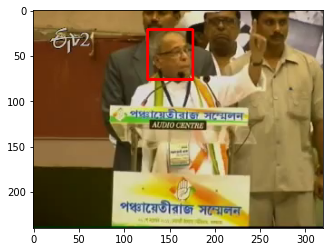

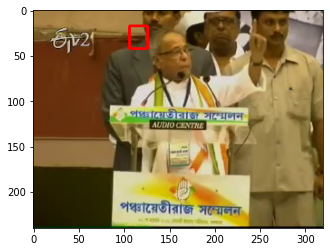

In [24]:


paths = ['frames/10181.png', 'frames/10181.png']
bboxess = [[(126,21,50,55)], [(106.79860929,  17.57010548,  20.06695618,  25.14948463)]]

for path, bboxes in zip(paths, bboxess):
    img_path = os.path.join(IMAGES_PATH, path)
    img = cv2.imread(img_path)
    align_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for bbox in bboxes:
        cv2.rectangle(align_rgb, (int(bbox[0]),int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])), (255,0,0), 2)

    plt.figure()
    plt.imshow(align_rgb)

plt.show()